In [ ]:
import json, os

#For grading make sure you make your own key for kaggle
username = "username"
key = "Upload your key"

# Create .kaggle folder
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Write the kaggle.json file
kaggle_dict = {
    "username": username,
    "key": key
}

with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_dict, f)

# Set correct permissions
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install kaggle # Access Kaggle API
!kaggle datasets download -d andrewmvd/medical-mnist # Download dataset from Kaggle
!unzip /content/medical-mnist.zip -d /content/medical-mnist # Unzip the dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/medical-mnist/HeadCT/005000.jpeg  
  inflating: /content/medical-mnist/HeadCT/005001.jpeg  
  inflating: /content/medical-mnist/HeadCT/005002.jpeg  
  inflating: /content/medical-mnist/HeadCT/005003.jpeg  
  inflating: /content/medical-mnist/HeadCT/005004.jpeg  
  inflating: /content/medical-mnist/HeadCT/005005.jpeg  
  inflating: /content/medical-mnist/HeadCT/005006.jpeg  
  inflating: /content/medical-mnist/HeadCT/005007.jpeg  
  inflating: /content/medical-mnist/HeadCT/005008.jpeg  
  inflating: /content/medical-mnist/HeadCT/005009.jpeg  
  inflating: /content/medical-mnist/HeadCT/005010.jpeg  
  inflating: /content/medical-mnist/HeadCT/005011.jpeg  
  inflating: /content/medical-mnist/HeadCT/005012.jpeg  
  inflating: /content/medical-mnist/HeadCT/005013.jpeg  
  inflating: /content/medical-mnist/HeadCT/005014.jpeg  
  inflating: /content/medical-mnist/HeadCT/005015.jpeg  
  inflating: /content/medical-mnist/H

# Building a Convolitional NN of Medical Image Classifier #

# Importing Libraries#

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Importing the Dataset

In [ ]:
# Path to the image dataset directory
dataset_directory = '/content/medical-mnist'

# Load the training dataset
# 60% of the total dataset will be used for training
X_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,
    image_size=(64, 64),     # Resize all images to 64x64 pixels
    labels='inferred',       # Automatically infer labels from folder names
    shuffle=True,            # Shuffle images to ensure randomness
    validation_split=0.4,   # Reserve 40% of the data for validation + testing
    subset="training",      # Select the training portion (60%)
    seed=123                # Fixed seed to ensure reproducible splits
)


# Load the combined validation and testing dataset
# This dataset represents the remaining 40% of the data
validation_and_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,
    image_size=(64, 64),     # Resize images to match training data
    labels='inferred',
    shuffle=True,            # Shuffle for randomness
    validation_split=0.4,   # Same split ratio as above
    subset="validation",    # Select the held-out data
    seed=123                # Same seed ensures consistent splitting
)


# Split the remaining 40% into validation and test sets
# Each will represent 20% of the total dataset

# Determine the size of each split
validation_size = len(validation_and_test_dataset) // 2
test_size = len(validation_and_test_dataset) - validation_size

# Use the first half as the validation dataset (20%)
X_cv = validation_and_test_dataset.take(validation_size)

# Use the remaining half as the test dataset (20%)
X_test = validation_and_test_dataset.skip(validation_size)


Found 58954 files belonging to 6 classes.
Using 35373 files for training.
Found 58954 files belonging to 6 classes.
Using 23581 files for validation.


# Build the Model #

Describe Architecture

In [ ]:
model = Sequential([

    # Input normalization layer
    # Scale pixel values from [0, 255] to [0, 1] to improve training stability
    tf.keras.layers.Rescaling(1./255),

    # Convolution Block 1
    # Apply 32 filters to learn low-level features such as edges and textures
    tf.keras.layers.Conv2D(
        32, (3, 3),
        activation='relu',
        padding='same',
        input_shape=(64, 64, 3)),

    # Reduce spatial dimensions and computational cost
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    # Convolution Block 2
    # Increase filter count to capture more complex patterns
    tf.keras.layers.Conv2D(
        64, (3, 3),
        padding='same',
        activation='relu'
    ),

    # Further downsample feature maps
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    # Convolution Block 3
    # Learn higher-level abstract features
    tf.keras.layers.Conv2D(
        128, (3, 3),
        padding='same',
        activation='relu'
    ),

    # Final pooling layer to compress spatial information
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    # Flatten layer
    # Convert 2D feature maps into a 1D feature vector
    tf.keras.layers.Flatten(),

    # Fully connected (dense) layers
    # Dense layer to combine extracted features
    tf.keras.layers.Dense(1024, activation='relu'),

    # Dropout to reduce overfitting by randomly disabling neurons
    tf.keras.layers.Dropout(0.5),

    # Additional dense layer for deeper feature learning
    tf.keras.layers.Dense(512, activation='relu'),

    # Additional dropout for regularization
    tf.keras.layers.Dropout(0.5),


    # Output layer
    # Softmax outputs probabilities for each of the 6 classes
    tf.keras.layers.Dense(6, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compile the Model

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Train the Model

In [ ]:
loss_plot = model.fit(X_train, epochs=10, validation_data=(X_cv))

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1106/1106 ━━━━━━━━━━━━━━━━━━━━ 474s 426ms/step - accuracy: 0.9392 - loss: 0.1619 - val_accuracy: 0.9931 - val_loss: 0.0220
Epoch 2/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 496s 420ms/step - accuracy: 0.9971 - loss: 0.0122 - val_accuracy: 0.9987 - val_loss: 0.0061
Epoch 3/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 490s 443ms/step - accuracy: 0.9964 - loss: 0.0147 - val_accuracy: 0.9990 - val_loss: 0.0029
Epoch 4/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 492s 434ms/step - accuracy: 0.9988 - loss: 0.0055 - val_accuracy: 0.9988 - val_loss: 0.0051
Epoch 5/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 479s 433ms/step - accuracy: 0.9965 - loss: 0.0152 - val_accuracy: 0.9985 - val_loss: 0.0114
Epoch 6/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 505s 436ms/step - accuracy: 0.9990 - loss: 0.0052 - val_accuracy: 0.9992 - val_loss: 0.0043
Epoch 7/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 483s 436ms/step - accuracy: 0.9988 - loss: 0.0063 - val_accuracy: 0.9990 - val_loss: 0.0064
Epoch 8/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 482s 435ms/step - accuracy: 0.9

# Assess Generalization #

Plot the accuracy and loss of training and validation set to monitor model's performance during training.

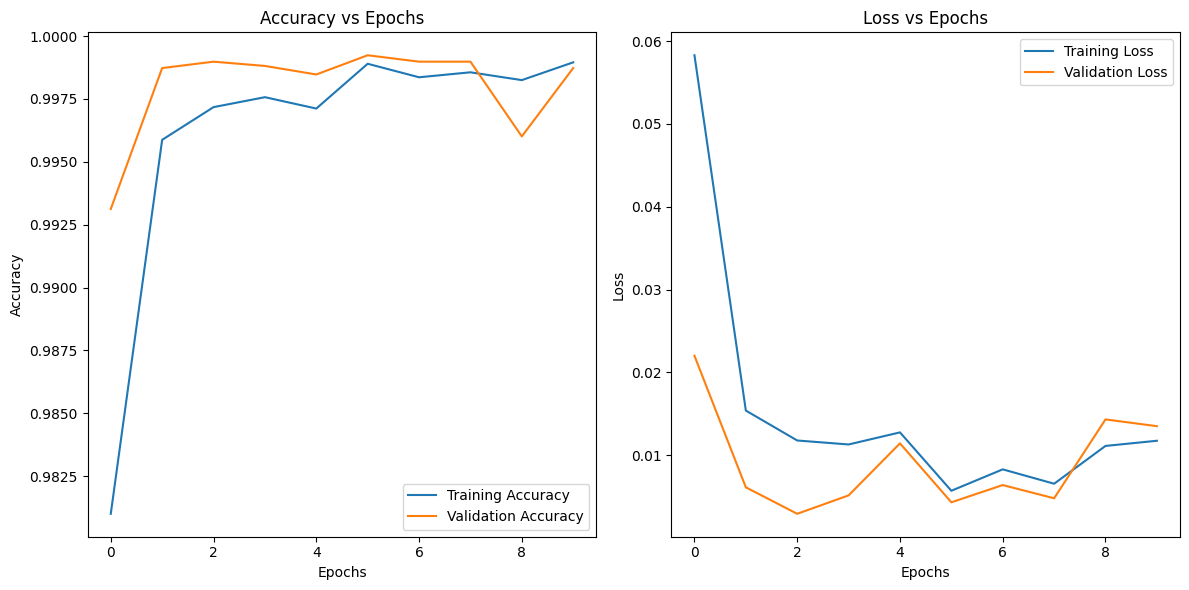

In [ ]:
# figure to display accuracy and loss plots side by side
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
# Create the first subplot (1 row, 2 columns, position 1)
plt.subplot(1, 2, 1)

# Plot model accuracy on the training dataset over epochs
plt.plot(loss_plot.history['accuracy'], label='Training Accuracy')

# Plot model accuracy on the validation dataset over epochs
plt.plot(loss_plot.history['val_accuracy'], label='Validation Accuracy')

# Add title and axis labels
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Display legend to distinguish training and validation curves
plt.legend()

# Plot training and validation loss
# Create the second subplot (1 row, 2 columns, position 2)
plt.subplot(1, 2, 2)

# Plot model loss on the training dataset over epochs
plt.plot(loss_plot.history['loss'], label='Training Loss')

# Plot model loss on the validation dataset over epochs
plt.plot(loss_plot.history['val_loss'], label='Validation Loss')

# Add title and axis labels
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display legend to distinguish training and validation curves
plt.legend()

# Adjust spacing to prevent overlapping elements
plt.tight_layout()

# Render the plots to the screen
plt.show()


# Evaluation #

Final evaluation of the model's performance on truly unseen data.

In [ ]:
test_loss, test_acc = model.evaluate(X_test)

369/369 ━━━━━━━━━━━━━━━━━━━━ 37s 96ms/step - accuracy: 0.9987 - loss: 0.0092
